In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score

import data_utilities as du
import model_utilities as mu

In [2]:
filestring1 = 'DSND_covid19_policy_tracker.csv'
filestring2 = 'worldmeter_info2020.csv'
merge_field = 'country_name'
covid = pd.read_csv(filestring1)
demos = pd.read_csv(filestring2)
covid = pd.merge(covid, demos, how='inner', on=merge_field)
covid = covid.drop(columns=['Unnamed: 0'], axis=1)


/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104877 entries, 0 to 104876
Data columns (total 57 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   country_name                             104877 non-null  object 
 1   alpha_3_code                             104877 non-null  object 
 2   region_name                              37152 non-null   object 
 3   region_code                              37152 non-null   object 
 4   date                                     104877 non-null  object 
 5   school_closing                           102029 non-null  float64
 6   school_closing_flag                      78892 non-null   float64
 7   school_closing_notes                     4593 non-null    object 
 8   workplace_closing                        102023 non-null  float64
 9   workplace_closing_flag                   72813 non-null   float64
 10  workplace_closing_notes         

#### Document preprocessing data transformations

In [48]:
covid['country_name'].value_counts()

United States     16053
Brazil             6508
Canada             3046
United Kingdom     1573
China               365
                  ...  
Eritrea              28
Mongolia             23
Seychelles           14
Bhutan               13
Faeroe Islands        6
Name: country_name, Length: 163, dtype: int64

Some countries, eg. the United States and Brazil, include regions in their tracking, vastly multiplying their datapoints. In comparison, China is tracked in total, with one datapoint per day.  Add a 'geo' column to increase analytic flexibility.

In [4]:
# Cleaning and filling
# drop all rows missing the target labels
covid = covid.dropna(subset=['deaths','confirmed_cases'], axis=0)
# drop all rows where target labels are zero
covid = covid.loc[(covid['confirmed_cases'] > 0.0) & (covid['deaths'] > 0.0)]
# drop all rows missing summary indicator
covid = covid.loc[covid['stringency_index'].notnull()]
# ensure date field is datetime to manipulate more easily
covid['date'] = pd.to_datetime(covid['date'])
# make regional data consistent: if NA, cumulative for the country
covid['region_name'] = covid['region_name'].fillna('Total')
# create a combined field to break up larger countries into regions
covid['geo'] = covid['country_name'] + covid['region_name']
# drop unused identifying columns
covid = covid.drop(['alpha_3_code','region_code'], axis=1)
# drop uncategorized policy columns
covid = covid.drop(['misc_wildcard','misc_wildcard_notes'], axis=1)
# subset the free text columns and drop them from main df
cols_notes = ['school_closing_notes','workplace_closing_notes',
             'cancel_public_events_notes','restrictions_on_gatherings_notes', 
             'stay_at_home_requirements_notes', 'restrictions_on_internal_movement_notes',
             'international_travel_controls_notes','income_support_notes',
             'debt_contract_relief_notes', 'fiscal_measures_notes', 
             'international_support_notes', 'public_information_campaigns_notes',
             'testing_policy_notes', 'contact_tracing_notes',
             'emergency_healthcare_investment_notes', 'vaccine_investment_notes']
covid_notes = covid[list(covid[cols_notes])]
covid = covid.drop(cols_notes, axis=1)



In [5]:
# normalize the raw statistics by population
covid['case_perc_pop'] = (covid['confirmed_cases'] / covid['population'])
covid['death_perc_pop'] = (covid['deaths'] / covid['population'])

In [6]:
# get the changes in target data over time
covid['case_perc_change'] = np.round(covid['confirmed_cases'].pct_change(), decimals=2)
covid['death_perc_change'] = np.round(covid['deaths'].pct_change(), decimals=2)
# remove calculation infinites
covid = covid.drop(covid.index[list(np.where(np.isfinite(covid['case_perc_change']) == False))])
covid = covid.drop(covid.index[list(np.where(np.isfinite(covid['death_perc_change']) == False))])

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [7]:
# get whether outcomes are increasing (0) or decreasing (1)
covid['case_direction'] = covid['case_perc_change'].apply(lambda x: 0 if x > 0 else 1)
covid['death_direction'] = covid['death_perc_change'].apply(lambda x: 0 if x > 0 else 1)

#### At this point, the outcomes to be analyzed are available in four formats:
* original: absolute and cumulative, columns confirmed_cases and deaths
* relative to population: columns case_perc_pop, death_perc_pop
* change over time: columns case_perc_change, death_perc_change
* direction over time: columns case_direction, death_direction

In [8]:
cols_outcomes = ['confirmed_cases', 'deaths','case_perc_pop', 'death_perc_pop',
               'case_perc_change','death_perc_change','case_direction','death_direction']


In [9]:
# enhance the summary metric, the stringency_index
# get the change in stringency_index
covid['stringency_change'] = np.round(covid['stringency_index'].pct_change(), decimals=2)
# remove calculation infinites
covid = covid.drop(covid.index[list(np.where(np.isfinite(covid['stringency_change']) == False))])
# get the stringency direction, are governments tightening (1) or loosening (0) policy?
covid['stringency_direction'] = covid['stringency_change'].apply(lambda x: 0 if x < 0 else 1)
# at this point, the summary metric is available in three formats
cols_stringency = ['stringency_index','stringency_change','stringency_direction']

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [10]:
# do quick cleaning step to prevent calculation errors
if covid.isnull().sum().sum() > 0:
    covid = covid.fillna(value=0)

In [11]:
# monetary values are different scale from binary or ordinal rankings
cols_financial_amts = ['income_support', 'debt_contract_relief',
                    'fiscal_measures', 'international_support',
                    'emergency_healthcare_investment', 'vaccine_investment']

In [12]:
scaler = MinMaxScaler()
for col in cols_financial_amts:
    # scale the financial amounts to range [0..1]
    sc_colname = 'scaled_'+col
    covid[sc_colname] = scaler.fit_transform(covid[[col]])
    # get the binary for whether policy was active (>0 allocated) or not
    bi_colname = col+'_flag'
    covid[bi_colname] = covid[col].apply(lambda x: 0 if x <= 0 else 1)

In [13]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73162 entries, 44 to 104488
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   country_name                            73162 non-null  object        
 1   region_name                             73162 non-null  object        
 2   date                                    73162 non-null  datetime64[ns]
 3   school_closing                          73162 non-null  float64       
 4   school_closing_flag                     73162 non-null  float64       
 5   workplace_closing                       73162 non-null  float64       
 6   workplace_closing_flag                  73162 non-null  float64       
 7   cancel_public_events                    73162 non-null  float64       
 8   cancel_public_events_flag               73162 non-null  float64       
 9   restrictions_on_gatherings              73162 no

#### Correlation analysis one: Policies active or not
For the first test of correlation, let's look at the dataset flags for which policies were active, and compare them with whether cases were going up or down, using scipy.stats for Pearsons and Spearmans.
Correlation is the degree to which any two data points are related. For statistical analysis, the <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html'>Pearson correlation coefficent</a> is the degree to which they are linearly related and is represented by a float between -1.0 and 1.0. The relationship is linear only when a change in one feature is associated with a proportional change in the other. A negative coefficient indicates an inverse relationship and a zero would be no relationship at all.  The Pandas corr function uses Pearson's calculation for correlation between numeric columns. (Note: I wrote my own function using scipy.stats for a slightly cleaner output.)
If you want a broader perspective, you can use scipy for <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html'>Spearman's correlation</a>. The difference is that Spearman does not assume a constant, proportional rate of change, simply that there is a directional change.  Spearman captures monotonic relationships as well as linear relationships. Spearman is generally considered best for ranked data.

In [14]:
cols_binary = ['geo','country_name', 'region_name','date',
        'case_direction','death_direction',
        'stringency_direction',
       'school_closing_flag', 'workplace_closing_flag',   
       'cancel_public_events_flag', 'restrictions_on_gatherings_flag',
       'close_public_transit_flag',
       'stay_at_home_requirements_flag',
       'restrictions_on_internal_movement_flag',
       'international_travel_controls',
       'income_support_flag', 
       'public_information_campaigns_flag',
       'testing_policy',
       'contact_tracing', 
       'debt_contract_relief_flag',
       'fiscal_measures_flag',
       'international_support_flag',
       'emergency_healthcare_investment_flag', 
       'vaccine_investment_flag']
covid_binary = covid[list(covid[cols_binary])]
covid_binary.shape

(73162, 24)

In [15]:
# get pearsons coefficient on binary policies and directional change in cases
cols_to_check = cols_binary[6:]
binary_corr = du.get_pearsons_corr(covid_binary, cols_to_check, 'case_direction')
impt_binaries = binary_corr.loc[(abs(binary_corr['corr']) > 0.10)]
impt_binaries.head()

,feature,corr
6,stay_at_home_requirements_flag,-0.113344
7,restrictions_on_internal_movement_flag,-0.147852
8,international_travel_controls,-0.153003


In [16]:
# try spearmans to get directional relationships
spearman_corr = du.get_spearmans_corr(covid_binary, cols_to_check, 'case_direction')
impt_sc_bin = spearman_corr.loc[(abs(spearman_corr['corr']) > 0.10)]
impt_sc_bin.head()

,feature,corr
6,stay_at_home_requirements_flag,-0.113344
7,restrictions_on_internal_movement_flag,-0.147852
8,international_travel_controls,-0.153692


In [17]:
cols_ordinal = ['geo','country_name', 'region_name','date',
                'case_direction','death_direction',
                'stringency_index',
                'school_closing', 'workplace_closing',
                'cancel_public_events', 'restrictions_on_gatherings',
                'close_public_transit', 'stay_at_home_requirements', 
                'restrictions_on_internal_movement','international_travel_controls',
                'public_information_campaigns','testing_policy',
                'contact_tracing',
                'scaled_income_support', 'scaled_debt_contract_relief',
               'scaled_fiscal_measures','scaled_international_support',
               'scaled_emergency_healthcare_investment','scaled_vaccine_investment',
               ]

In [18]:
covid_ordinal = covid[list(covid[cols_ordinal])]
covid_ordinal.shape

(73162, 24)

In [19]:
ords_to_check = cols_ordinal[6:]
pc_ordinal_corr = du.get_pearsons_corr(covid_ordinal, ords_to_check, 'case_direction')
impt_ordinals = pc_ordinal_corr.loc[(abs(pc_ordinal_corr['corr']) > 0.10)]
impt_ordinals.head()

,feature,corr
0,stringency_index,-0.255482
1,school_closing,-0.233336
2,workplace_closing,-0.218563
3,cancel_public_events,-0.176596
4,restrictions_on_gatherings,-0.139175


In [20]:
# try spearmans to get directional relationships
sc_ordinal_corr = du.get_spearmans_corr(covid_ordinal, ords_to_check, 'case_direction')
impt_sc_ord = sc_ordinal_corr.loc[(abs(sc_ordinal_corr['corr']) > 0.10)]
impt_sc_ord.head()

,feature,corr
0,stringency_index,-0.240809
1,school_closing,-0.230582
2,workplace_closing,-0.203351
3,cancel_public_events,-0.160389
4,restrictions_on_gatherings,-0.162824


#### Build data visualizations to demonstrate data explorations
Let's visualize some of the features showing correlations.

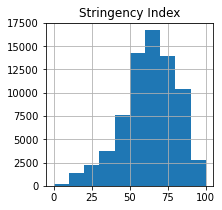

In [21]:
#covid['stringency_index'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('stringency_index', ax=ax)
ax.set_title('Stringency Index')
fig.savefig('stringency_index_hist_3x3.png', bbox_inches='tight')
plt.show()

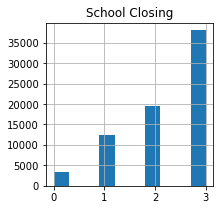

In [22]:
# covid['school_closing'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('school_closing', ax=ax)
ax.set_title('School Closing')
fig.savefig('school_closing_hist_3x3.png', bbox_inches='tight')
plt.show()

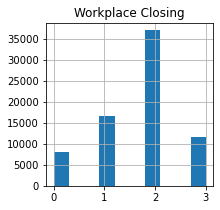

In [23]:
# covid['workplace_closing'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('workplace_closing', ax=ax)
ax.set_title('Workplace Closing')
fig.savefig('workplace_closing_hist_3x3.png', bbox_inches='tight')
plt.show()

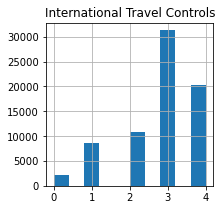

In [24]:
# covid['international_travel_controls'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('international_travel_controls', ax=ax)
ax.set_title('International Travel Controls')
fig.savefig('international_travel_contols_hist_3x3.png', bbox_inches='tight')
plt.show()

In [25]:
potential_factors = ['stringency_index','school_closing',
                'workplace_closing', 'international_travel_controls']

/Users/lquera/Dropbox/DSND/DSND_Project_Capstone/data_utilities.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['date'] = pd.to_datetime(comp_df['date'])


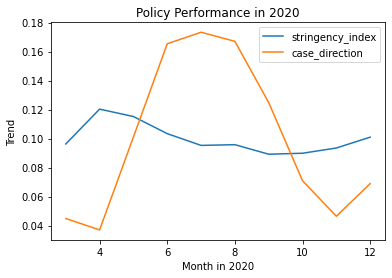

<Figure size 432x288 with 0 Axes>

In [26]:
du.compare_policy_outcomes(covid, 'Canada', 'stringency_index', 'case_direction')

In [27]:
cols_demos = ['geo','country_name', 'region_name','date',
                'case_perc_pop','death_perc_pop',
                'urban_perc', 'median_age','density'
               ]

In [28]:
covid_demos = covid[list(covid[cols_demos])]
covid_demos.shape

(73162, 9)

In [29]:
# just to validate the use of scatter plot rather than scipy corrs
demos_to_check = cols_demos[6:]
pc_demos_corr = du.get_pearsons_corr(covid_demos, demos_to_check, 'case_perc_pop')
impt_demos = pc_demos_corr.loc[(abs(pc_demos_corr['corr']) > 0.10)]
impt_demos.head()

,feature,corr


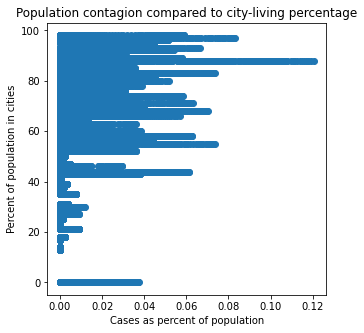

In [30]:
#pd.plotting.scatter_matrix(covid_demos[['case_perc_pop','urban_perc']], figsize=(15,15))

plt.scatter(covid_demos['case_perc_pop'], covid_demos['urban_perc'])
plt.xlabel('Cases as percent of population')
plt.ylabel('Percent of population in cities')
plt.title('Population contagion compared to city-living percentage')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.savefig('case_perc_pop_and_urban_perc_5x5.png')
plt.show()

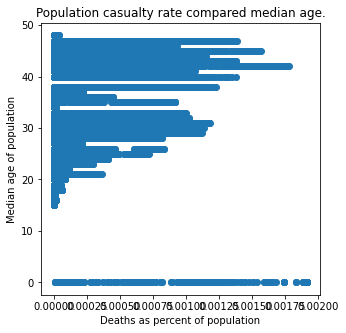

In [31]:
plt.scatter(covid_demos['death_perc_pop'], covid_demos['median_age'])
plt.xlabel('Deaths as percent of population')
plt.ylabel('Median age of population')
plt.title('Population casualty rate compared median age.')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.savefig('death_perc_pop_and_median_age_5x5.png')
plt.show()

## Modeling for feature understanding

Another approach to understanding policies and outcomes, is to use models to identify which features improve predictive capability. Let's look at feature selection and feature importance.

Feature selection is the process of testing the relationships between each training feature and the target feature and selecting the ones with the strongest relationship. It shows the impact of the variable on the model success metric and the higher it is, the more valuable the feature's predictive capability. Negative feature importance means that the feature increases the loss and either the model is underfitting or the model would benefit from removing the feature.

SelectKBest is a univariate method that uses statistical means to evaluate the relationships and keeps the K highest-scoring features. RFE (Recursive Feature Elimination) fits a model on all features and then recursively eliminates the one with the lowest importance score until it gets to the K highest scoring features.

You can use feature selection in your model training process and then access the feature_importance_ attribute to visualize which features impacted the model most.  I chose Random Forests (an ensemble of bagged Decision Trees) because the random splits create better tree diversity with less overfitting than simple Decision Trees. The feature importances are weighted averages of how much the feature reduces impurities across all trees in the forest.

First, let’s look at using SelectKBest feature selection for a RandomForestRegressor optimized for the Mean Absolute Error.

A note on metrics: MAE, mean absolute error, is best suited to the task at hand because my goal is interpretability, teasing out the underlying relationships of policies and outcomes.  MAE is considered superior for interpretability because it simply describes average errors and is not as impacted by test sample size.  The downside is the significantly larger computation time. (“When the random forest regressor optimizes for MSE it optimizes for the L2-norm and a mean-based impurity metric. But when the regressor uses the MAE criterion it optimizes for the L1-norm which amounts to calculating the median.”[https://stackoverflow.com/questions/57243267/why-is-training-a-random-forest-regressor-with-mae-criterion-so-slow-compared-to])

In [32]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[6:]
target = 'case_perc_change'
# Feature Selection
n_features = 12
selection = 'stat'
problem_type = 'regression'
scoring = 'f_regression'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 100
criterion = 'mae'

In [33]:
X_train, X_test, y_train, y_test, stat_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(51213, 12) (51213,) (21949, 12) (21949,)


/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
rfstat = RandomForestRegressor(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfstat, rfstat_results = mu.train_and_score_model(rfstat, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestRegressor')

RandomForestRegressor
R2 train: -0.000, test: -0.000
MSE train: 53075.534, test: 4885.406
MAE train: 1.119, test: 0.529


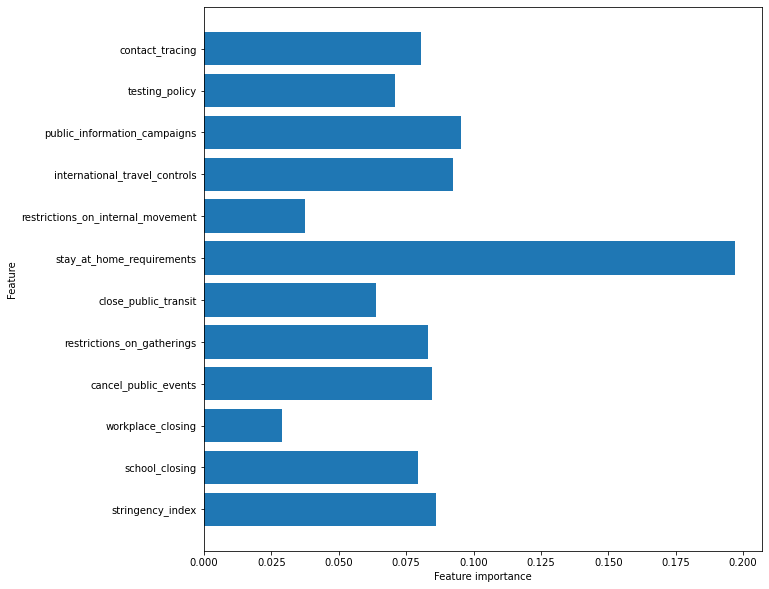

In [36]:
mu.visualize_feature_importance(rfstat, X_train, stat_features_used, selection, 'tree')

#### Does Recursive Feature Elimination return different features?
Next, let’s look at using Recursive Feature Elimination feature selection for a RandomForestRegressor optimized for the Mean Absolute Error

In [37]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[6:]
target = 'case_perc_change'
# Feature Selection
n_features = 12
selection = 'RFE'
problem_type = 'regression'
scoring = 'f_regression'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 30
criterion = 'mae'

In [38]:
X_train, X_test, y_train, y_test, rfe_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


[2 1 1 1 1 1 1 1 1 1 5 6 4 7 1 3 1 1]
drop stringency_index
keep school_closing
keep workplace_closing
keep cancel_public_events
keep restrictions_on_gatherings
keep close_public_transit
keep stay_at_home_requirements
keep restrictions_on_internal_movement
keep international_travel_controls
keep public_information_campaigns
drop testing_policy
drop contact_tracing
drop scaled_income_support
drop scaled_debt_contract_relief
keep scaled_fiscal_measures
drop scaled_international_support
keep scaled_emergency_healthcare_investment
keep scaled_vaccine_investment
(51213, 12) (51213,) (21949, 12) (21949,)


In [39]:
rfrfe = RandomForestRegressor(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfrfe, rfrfe_results = mu.train_and_score_model(rfrfe, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestRegressor')

RandomForestRegressor
R2 train: -0.000, test: -0.000
MSE train: 53075.833, test: 4885.421
MAE train: 1.121, test: 0.531


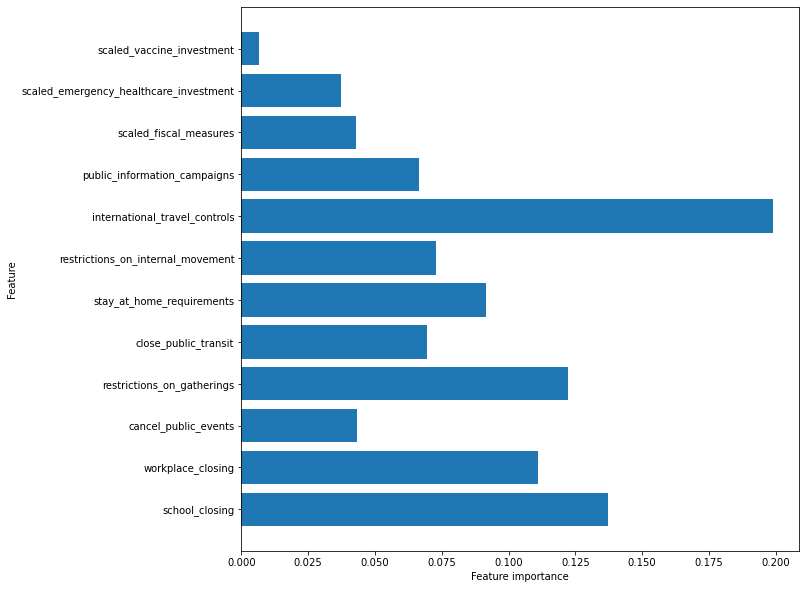

In [40]:
mu.visualize_feature_importance(rfrfe, X_train, rfe_features_used, selection, 'tree')

### Reframe as binary classification problem
Lastly, since we calculated the directional change of the outcomes, we can reformulate the problem to a binary classification - cases up or cases down. Let’s see if that makes anything clearer using SelectKBest feature selection for a RandomForestClassifier optimized for information gain, ie. entropy.

In [43]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[6:]
target = 'case_direction'
# Feature Selection
n_features = 12
selection = 'stat'
problem_type = 'classification'
scoring = 'chi2'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 30
criterion = 'entropy'

In [44]:
X_train, X_test, y_train, y_test, rfc_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(51213, 12) (51213,) (21949, 12) (21949,)


/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [45]:
rfc = RandomForestClassifier(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfc, rfc_results = mu.train_and_score_model(rfc, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestClassifier')

RandomForestClassifier
Accuracy train: 0.860, test: 0.837
Precision train: 0.810, test: 0.781
Recall train: 0.754, test: 0.721


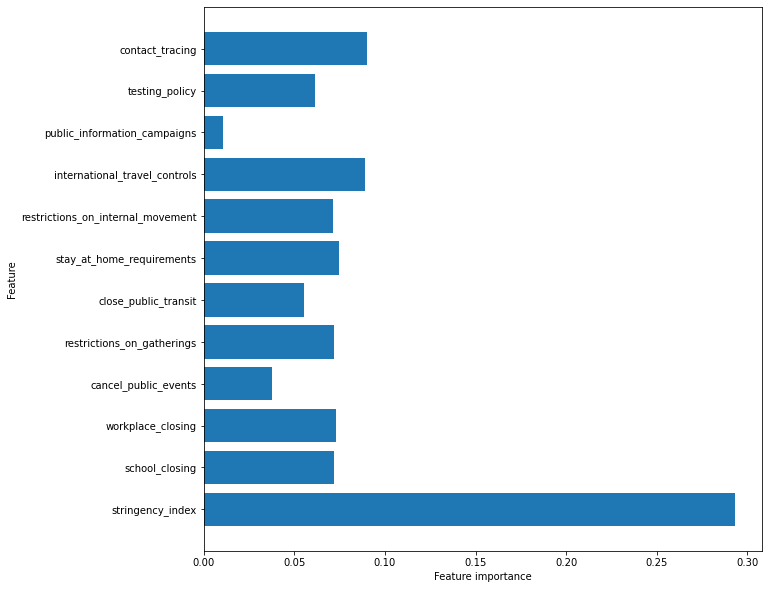

In [46]:
mu.visualize_feature_importance(rfc, X_train, rfc_features_used, selection, 'tree')